# 预测药物MoA
一个样本可以有为一个或多个MoA标记，属于多标签分类任务(MultiLabel Classification)

kaggle: https://www.kaggle.com/competitions/lish-moa/overview

## Import

In [1]:
import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import log_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## Data

EDA refences: https://www.kaggle.com/code/amiiiney/drugs-moa-classification-eda/notebook#1-Overview:-Features

In train_features: 
- Features **g-** signify gene expression data.

- Features **c-** signify cell viability data.
 
- **cp_type** indicates samples treated with a compound, **trt_cp** samples treated with the compounds.**ctl_vehicle**; control perturbations have no MoAs.

- **cp_time** and **cp_dose** indicate treatment duration (24, 48, 72 hours) and dose (high or low).

In [3]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_noscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')

train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
train_features.shape, train_targets_scored.shape, train_targets_noscored.shape, test_features.shape

((23814, 876), (23814, 207), (23814, 403), (3982, 876))

In [5]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

len(GENES), len(CELLS)

(772, 100)

In [6]:
train_features['cp_type'].unique()

array(['trt_cp', 'ctl_vehicle'], dtype=object)

<AxesSubplot:ylabel='Count'>

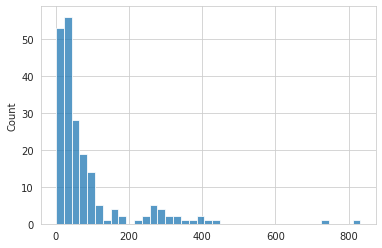

In [7]:
target_count = train_targets_scored.sum()[1:].sort_values()
sns.set_style('whitegrid')
sns.histplot(target_count)

## Preprocess

In [8]:
def map(df):
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 1, 'ctl_vehicle': 0})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    return df

train_features = map(train_features)
test_features = map(test_features)

### PCA features + Existing features

In [9]:
# GENE
n_comp = 50

data = pd.concat([train_features[GENES], test_features[GENES]])
data2 = PCA(n_components=n_comp, random_state=42).fit_transform(data)

train2 = data2[:len(train_features)]
test2 = data2[len(train_features):]

train2 = pd.DataFrame(train2, columns=[f'g-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'g-{i}' for i in range(n_comp)])

train_features = pd.concat([train_features, train2], axis=1)
test_features = pd.concat([test_features, test2], axis=1)

train_features.shape, test_features.shape

((23814, 926), (3982, 926))

In [10]:
# CELL
n_comp = 15

data = pd.concat([train_features[CELLS], test_features[CELLS]])
# PCA 返回的是numpy array
data2 = PCA(n_components=n_comp, random_state=42).fit_transform(data)

train2 = data2[:len(train_features)]
test2 = data2[len(train_features):]

train2 = pd.DataFrame(train2, columns=[f'c-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'c-{i}' for i in range(n_comp)])

train_features = pd.concat([train_features, train2], axis=1)
test_features = pd.concat([test_features, test2], axis=1)

train_features.shape, test_features.shape

((23814, 941), (3982, 941))

### feature selection by VarianceThreshold

In [11]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(threshold=0.5)
data = pd.concat([train_features, test_features])
# transform 返回的是numpy array
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_transformed = data_transformed[:len(train_features)]
test_transformed = data_transformed[len(train_features):]

train_features = pd.concat([train_features.iloc[:, :4], pd.DataFrame(train_transformed)], axis=1)
test_features = pd.concat([test_features.iloc[:, :4], pd.DataFrame(test_transformed)], axis=1)

train_features.shape, test_features.shape

((23814, 931), (3982, 931))

In [12]:
train = train_features.merge(train_targets_scored, on='sig_id')

train = train[train_features['cp_type'] == 1].reset_index(drop=True)
test = test_features[test_features['cp_type'] == 1].reset_index(drop=True)
target = train[train_targets_scored.columns]

train.drop('cp_type', axis=1, inplace=True)
test.drop('cp_type', axis=1, inplace=True)

train.shape, test.shape, target.shape

((21948, 1136), (3624, 930), (21948, 207))

### Distribution plots

In [13]:
# plt.figure(figsize=(16, 16))
# gene_choice = np.random.choice(len(GENES), 16)

# for i, col in enumerate(gene_choice):
#     plt.subplot(4, 4, i + 1)
#     plt.hist(train_features.loc[:, col], bins=100, color='orange')
#     plt.title(GENES[col])

### Cross Validation

由于样本的类别数存在不平衡，普通`Kfold`随机分类可能会导致训练集标签全为某个单一类别，而`StratifiedKFold`会按比例进行划分。
但是scikit-learn的StratifiedKFold不能用于多标签分类

In [14]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=5)
    
for f, (train_idx, valid_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[valid_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0,0,0,0,0,0,0,0,0,2
1,id_000779bfc,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,0,0,0,0,0,0,0,0,0,3
2,id_000a6266a,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,0,0,0,0,0,0,0,0,0,3
4,id_001626bd3,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,0,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,...,0,0,0,0,0,0,0,0,0,4
21944,id_fffb1ceed,24,1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,...,0,0,0,0,0,0,0,0,0,4
21945,id_fffb70c0c,24,1,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,...,0,0,0,0,0,0,0,0,0,2
21946,id_fffcb9e7c,24,0,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,...,0,0,0,0,0,0,0,0,0,4


In [15]:
target_col = target.drop('sig_id', axis=1).columns.values.tolist()
feature_col = [col for col in train.columns if col not in target_col]
feature_col = [col for col in feature_col if col not in ['sig_id']]

print(train.shape, test.shape, target.shape, folds.shape)
print(len(feature_col), len(target_col))

(21948, 1136) (3624, 930) (21948, 207) (21948, 1137)
929 206


## Dataset

In [16]:
class MoADataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __getitem__(self, idx):
        return {
            'x': torch.tensor(self.features[idx, :], dtype=torch.float32),
            'y': torch.tensor(self.targets[idx, :], dtype=torch.float32)
        }

    def __len__(self):
        return len(self.features)

class TestDataset(Dataset):
    def __init__(self, features):
        self.features = features
    
    def __getitem__(self, idx):
        return {
            'x': torch.tensor(self.features[idx, :], dtype=torch.float32)
        }

    def __len__(self):
        return len(self.features)

## Training functions

In [17]:
def train_fn(model, optimizer, scheduler, criterion, dataloader, device):
    model.train()
    final_loss = 0

    for data in dataloader:
        optimizer.zero_grad()
        input, target = data['x'].to(device), data['y'].to(device)
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        final_loss += loss.item()

    return final_loss / len(dataloader)

def valid_fn(model, dataloader, criterion, device):
    model.eval()
    final_loss = 0
    valid_preds = []

    for data in dataloader:
        input, target = data['x'].to(device), data['y'].to(device)
        output = model(input)
        loss = criterion(output, target)

        final_loss += loss.item()
        valid_preds.append(output.sigmoid().detach().cpu().numpy())

    final_loss = final_loss / len(dataloader)
    valid_preds = np.concatenate(valid_preds)   # list -> numpy array(matrix)
    return final_loss , valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    final_preds = []

    with torch.no_grad():
        for data in dataloader:
            input = data['x'].to(device)
            output = model(input)
            final_preds.append(output.sigmoid().detach().cpu().numpy())

    final_preds = np.concatenate(final_preds)
    return final_preds

## Model

In [18]:
class Model(nn.Module):
    def __init__(self, num_features, hidden_size, num_targets):
        super().__init__()
        self.model = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.2),
            nn.Linear(num_features, hidden_size),
            nn.LeakyReLU(),

            # nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            
            # nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),

            # nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),

            # nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),

            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, num_targets),
        )

    def forward(self, x):
        return self.model(x)

## Single Fold Training

In [19]:
# Hyperparameters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
epochs = 30
batch_size = 1024
learning_rate = 1e-3
weight_decay = 1e-5
nfolds = 5
early_stop_step = 10
early_stop = False

num_features = len(feature_col)
hidden_size = 2048
num_targets = len(target_col)

In [20]:
def run_training(fold):
    train_idx = train[folds['kfold'] != fold].index
    valid_idx = train[folds['kfold'] == fold].index


    train_df = train[folds['kfold'] != fold].reset_index(drop=True)
    valid_df = train[folds['kfold'] == fold].reset_index(drop=True)

    x_train, y_train = train_df[feature_col].values, train_df[target_col].values
    x_valid, y_valid = valid_df[feature_col].values, valid_df[target_col].values

    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    model = Model(num_features, hidden_size, num_targets).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
    criterion = nn.BCEWithLogitsLoss()

    best_loss = np.inf
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))

    for epoch in range(epochs):
        train_loss = train_fn(model, optimizer, scheduler, criterion, train_dataloader, device)
        valid_loss, valid_preds = valid_fn(model, valid_dataloader, criterion, device)

        if valid_loss < best_loss:
            best_loss = valid_loss
            early_stop = 0
            torch.save(model.state_dict(), f'FOLD{fold}_.pth')
        else:
            early_stop += 1

        if early_stop >= early_stop_step:
            print(f'Early stop at epoch {epoch + 1}')
            break

        print(f'Fold {fold} | Epoch {epoch + 1} | train loss: {train_loss:.4f} | valid loss: {valid_loss:.4f}')

    # <-------------- inference ---------------->/
    x_test = test[feature_col].values
    test_dataset = TestDataset(x_test)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model = Model(num_features, hidden_size, num_targets)
    model.load_state_dict(torch.load(f'FOLD{fold}_.pth'))
    model.to(device)

    predictions = inference_fn(model, test_dataloader, device)

    return oof, predictions

In [21]:
def run_k_fold(nfolds):
    oof = np.zeros((len(train), len(target_col)))
    predictions = np.zeros((len(test), len(target_col)))

    for fold in range(nfolds):
        oof_, pred_ = run_training(fold)
        oof += oof_
        predictions += pred_ / nfolds

    return oof, predictions

In [22]:
oof, predictions = run_k_fold(nfolds)
# 将输出存入原dataframe的target列
train[target_col] = oof
test[target_col] = predictions

Fold 0 | Epoch 1 | train loss: 0.6999 | valid loss: 0.6543
Fold 0 | Epoch 2 | train loss: 0.5820 | valid loss: 0.4819
Fold 0 | Epoch 3 | train loss: 0.3227 | valid loss: 0.1750
Fold 0 | Epoch 4 | train loss: 0.1257 | valid loss: 0.0535
Fold 0 | Epoch 5 | train loss: 0.0489 | valid loss: 0.0324
Fold 0 | Epoch 6 | train loss: 0.0339 | valid loss: 0.0282
Epoch 00120: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00125: reducing learning rate of group 0 to 1.0000e-05.
Fold 0 | Epoch 7 | train loss: 0.0288 | valid loss: 0.0268
Epoch 00135: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00139: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00143: reducing learning rate of group 0 to 1.0000e-08.
Fold 0 | Epoch 8 | train loss: 0.0278 | valid loss: 0.0271
Fold 0 | Epoch 9 | train loss: 0.0275 | valid loss: 0.0268
Fold 0 | Epoch 10 | train loss: 0.0276 | valid loss: 0.0267
Fold 0 | Epoch 11 | train loss: 0.0279 | valid loss: 0.0269
Fold 0 | Epoch 12 | train loss: 0.0277 

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


## Submit

In [23]:
train_targets_scored.shape, len(target_col)

((23814, 207), 206)

In [24]:
valid_results = train_targets_scored.drop(columns=target_col).merge(train[['sig_id']+target_col], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_col].values
y_pred = valid_results[target_col].values

score = 0
for i in range(len(target_col)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)

CV log_loss:  0.11801833565930656


In [25]:
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
sub = sample_submission.drop(columns=target_col).merge(test[['sig_id']+target_col], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)